In [517]:
from preprocessing.DataList import *

import torch
import cv2
import matplotlib.pyplot as plt
# Set default figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Extracting the data

In [536]:
# Extract the training data  
labelPath = '/Users/rezaasad/Documents/CMPT742/Project01/data/training_data/LFW_annotation_train.txt'
baseImagePath = '/Users/rezaasad/Documents/CMPT742/Project01/data/lfw'
data = DataList(labelPath, baseImagePath)
# Create a data list
data.MakeList()

## Visualization of the input
Now let's try to visualize some of the images to make sure they are as expected. Most importantly <br/>
we want to see if the land marks are where they are supposed to be.

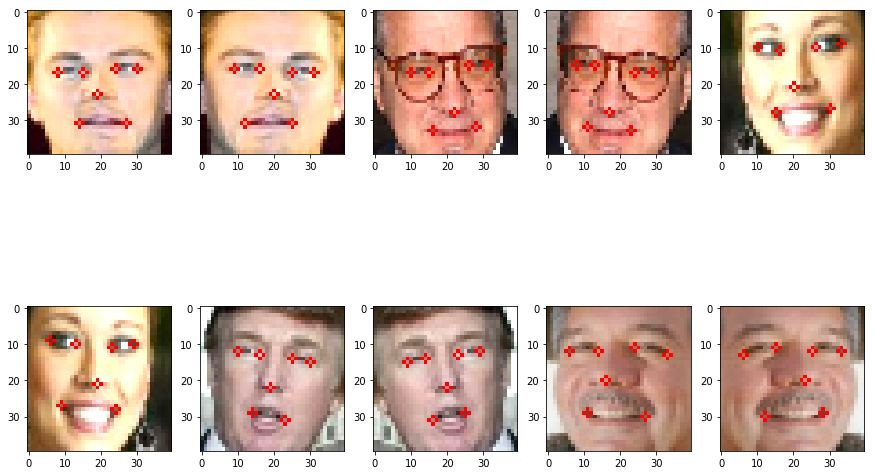

In [537]:
NUM_IMGS = 10
Xsample = data.X[:NUM_IMGS].copy()
ySample = data.y[:NUM_IMGS].copy()

for i in range(1,NUM_IMGS+1):
    img = np.asarray(Xsample[i-1])
    # Move the channel to the last dimension and transform back to
    # to the range [0, 255]
    img = img.astype('uint8')
    img = np.ascontiguousarray(img)
    # Add the landmarks
    landMarks = np.asarray(ySample[i-1])
    for j, (x,y) in enumerate(landMarks):
        cv2.circle(img, (x,y), 1, 255.0, thickness=1)
    # Plot the image
    plt.subplot(2, NUM_IMGS/2, i)
    plt.imshow(img, )
plt.show()

## Splitting data to train and validation

In [538]:
data.DataSplit()

Shuffling chunk 0 / 100
Shuffling chunk 20 / 100
Shuffling chunk 40 / 100
Shuffling chunk 60 / 100
Shuffling chunk 80 / 100


## Let's save the DataLists that we created in hdf5 format
First I'm going to dump the train and validation data into hdf5

In [539]:
import h5py 

# Make sure the file is not already open
try:
    hdf5.close()
except:
    print("The file is not open. Proceeding with saving the data ...")
    
hdf5 = h5py.File('data.h5', 'w')

hdf5.create_dataset('Xtrain', data=data.Xtrain, dtype=np.float32)
hdf5.create_dataset('yTrain', data=data.yTrain, dtype=np.float32)
hdf5.create_dataset('Xval', data=data.Xval, dtype=np.float32)
hdf5.create_dataset('yVal', data=data.yVal, dtype=np.float32)
hdf5.close()

In [540]:
# Now we can load the train and validation datasets.
hdf5 = h5py.File('data.h5', 'r')
Xtrain = np.asarray(hdf5.get('Xtrain'))
yTrain = np.asarray(hdf5.get('yTrain'))
Xval = np.asarray(hdf5.get('Xval'))
yVal = np.asarray(hdf5.get('yVal'))

print("Training data has shape: {}". format(Xtrain.shape))
print("Validation data has shape: {}". format(Xval.shape))
hdf5.close()

Training data has shape: (800, 40, 40, 3)
Validation data has shape: (200, 40, 40, 3)


## Let's feed the data to DataLoader

In [597]:
from preprocessing.DataSet import *
from torch.utils.data import DataLoader
from utility.Solver import *

trainDataSet = LFWDataset(Xtrain, yTrain)
valDataSet = LFWDataset(Xval, yVal)
solver = Solver(trainDataSet, valDataSet, batchSize=64)

The batch has shape: torch.Size([64, 3, 224, 224])
There are 14 land mark coordinates on each face


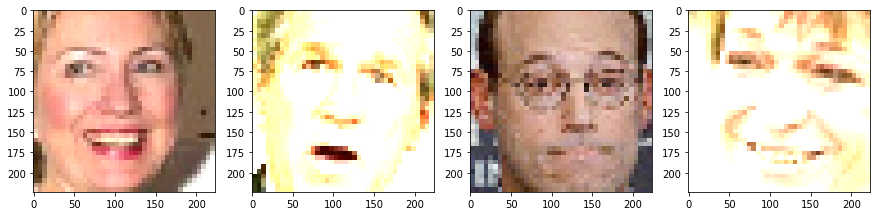

In [598]:
# Now I'm going to read a few data examples from the DataLoader and plot them
idx, (imgages, landMarks) = next(enumerate(solver.trainLoader))

print("The batch has shape: {}".format(imgages.shape))
print("There are {} land mark coordinates on each face".format(len(landMarks[0])))

NUM_IMGS = 4
for i in range(1, NUM_IMGS+1):
    img = np.asarray(imgages[i-1]).transpose(1, 2, 0)
    img = (1+img) * 255.0 / 2.0
    img = np.ascontiguousarray(img.astype('uint8'))
    plt.subplot(1, NUM_IMGS, i)
    plt.imshow(img)
plt.show()

## We are now going to use transfer learning to detect land marks.
I'm going to do the following steps:
* Download the pretrained alexnet model.
* Create an instance of my fully connected model (LandMarkAlexNet).
* Set the classifier portion of alexnet to the one I created.

In [599]:
# Downloading the pretrained alexnet
from torchvision import models

resnet = models.resnet18(pretrained=True)

In [605]:
for i, param in enumerate(resnet.parameters()):
    param.requires_grad = False

for i, param in enumerate(resnet.layer4[1].parameters()):
    param.requires_grad = True


In [602]:
# First I will freeze the feature parameters for the pretrained alexnet
# for param in alexNet.features.parameters():
#     param.require_grad = False

# Now I extract the number of input features for the classifier portion of
# the alexnet model
numInFeatures = resnet.fc.in_features

In [603]:
from models.ResnetClassifier import * 

# Let's create an instance of my model and set the classifier portion of
# the alexnet to my model.
model = ResnetClassifier(numInFeatures)
resnet.fc = model

In [604]:
# Let's train the model
optimizer = torch.optim.Adam(resnet.parameters(), lr = 1e-3, weight_decay=0.001)
trainLoss, validationLoss, finalAccuracy = solver.train(resnet, optimizer, numEpochs=5, printEvery=10)

This is epoch 0
Epoch 0, iteration 0 : loss is 0.27
The accuracy on validation set for radius 0.5263157894736842 is: 0.2935714285714286
Epoch 0, iteration 10 : loss is 0.09
The accuracy on validation set for radius 0.5263157894736842 is: 0.5642857142857143
--------
This is epoch 1
Epoch 1, iteration 0 : loss is 0.05
The accuracy on validation set for radius 0.5263157894736842 is: 0.7085714285714285
Epoch 1, iteration 10 : loss is 0.02
The accuracy on validation set for radius 0.5263157894736842 is: 0.9557142857142857
--------
This is epoch 2
Epoch 2, iteration 0 : loss is 0.02
The accuracy on validation set for radius 0.5263157894736842 is: 0.9664285714285714
Epoch 2, iteration 10 : loss is 0.01
The accuracy on validation set for radius 0.5263157894736842 is: 0.9928571428571429
--------
This is epoch 3
Epoch 3, iteration 0 : loss is 0.01
The accuracy on validation set for radius 0.5263157894736842 is: 0.995
Epoch 3, iteration 10 : loss is 0.01
The accuracy on validation set for radius 

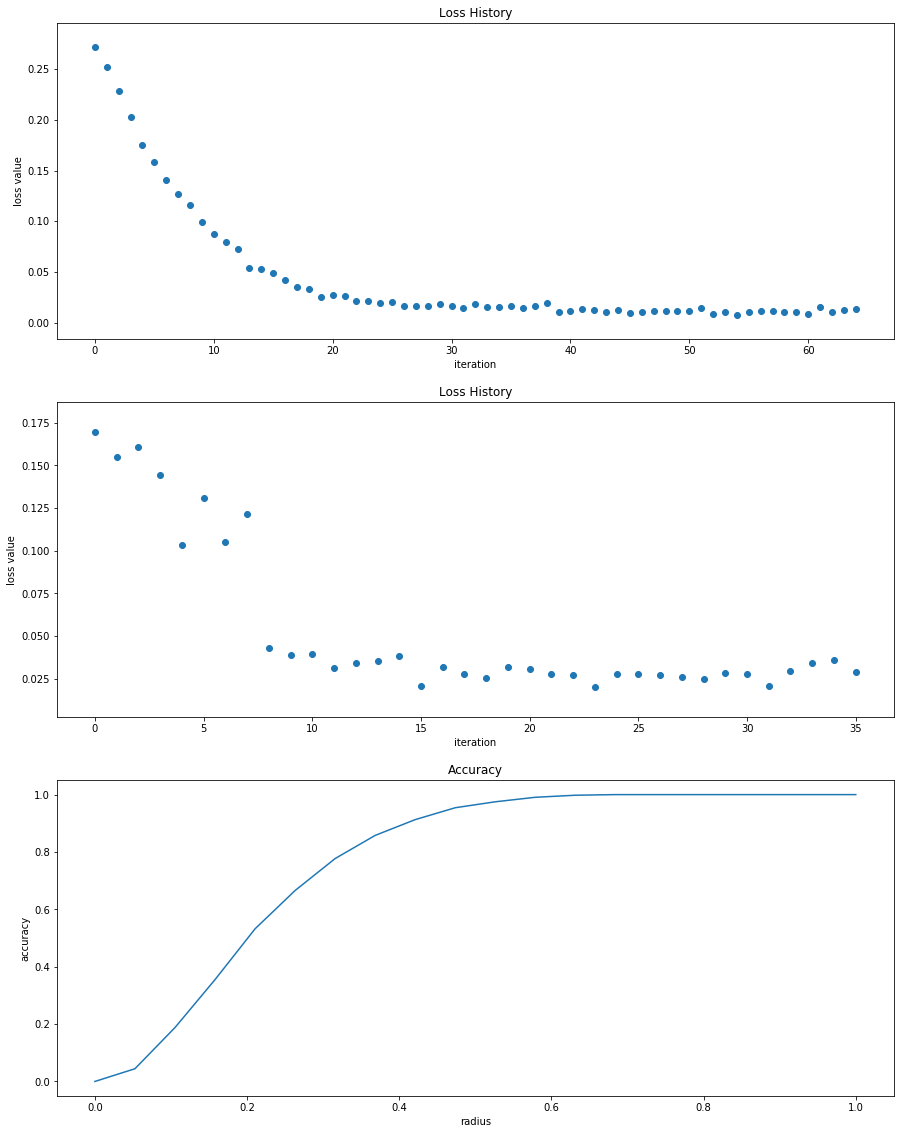

In [606]:
# Let's take a look at the trainig and validation loss history 
plt.subplots_adjust(bottom=0.01, top=1.5)
plt.subplot(3, 1, 1)
plt.title("Loss History")
plt.xlabel("iteration")
plt.ylabel("loss value")
plt.scatter(range(len(trainLoss)), trainLoss)

plt.subplot(3, 1, 2)
plt.title("Loss History")
plt.xlabel("iteration")
plt.ylabel("loss value")
plt.scatter(range(len(validationLoss[4:])), validationLoss[4:])

plt.subplot(3, 1, 3)
plt.title("Accuracy")
plt.xlabel("radius")
plt.ylabel("accuracy")
plt.plot(finalAccuracy.keys(), finalAccuracy.values())


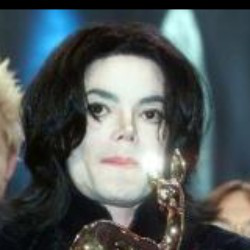

In [471]:
import PIL
path = '/Users/rezaasad/Documents/CMPT742/Project01/data/lfw/Michael_Jackson/Michael_Jackson_0002.jpg'
img = Image.open(path)
img